In [34]:
# importing necessary libraries

#import pyforest
from numpy import arange
%matplotlib inline 
#without this plt.show won't show the plot in first run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv("Training Data - Classification of Patients with Abnormal Blood Pressure.csv")
df.head()

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,0,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0


In [36]:
df.size

30000

### Pre-processing of data

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_Number                 2000 non-null   int64  
 1   Blood_Pressure_Abnormality     2000 non-null   int64  
 2   Level_of_Hemoglobin            2000 non-null   float64
 3   Genetic_Pedigree_Coefficient   1908 non-null   float64
 4   Age                            2000 non-null   int64  
 5   BMI                            2000 non-null   int64  
 6   Sex                            2000 non-null   int64  
 7   Pregnancy                      442 non-null    float64
 8   Smoking                        2000 non-null   int64  
 9   Physical_activity              2000 non-null   int64  
 10  salt_content_in_the_diet       2000 non-null   int64  
 11  alcohol_consumption_per_day    1758 non-null   float64
 12  Level_of_Stress                2000 non-null   i

In [38]:
df.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

Seems, we have missing values in the column of interest i.e. "Genetic_Pedigree_Coefficient". Let's check the distribution of the column.

<Axes: ylabel='Density'>

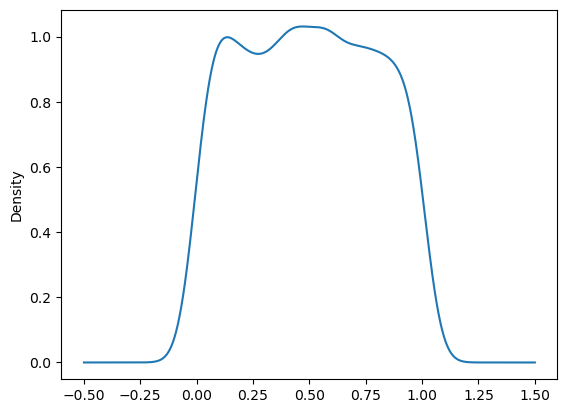

In [39]:
df["Genetic_Pedigree_Coefficient"].plot.kde()

Appears to be a mulitmodal distribution. A boxplot will give us idea about the presence of outliers.

<Axes: >

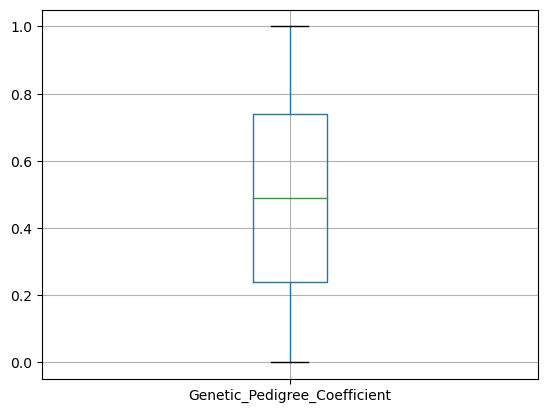

In [40]:
df.boxplot(column="Genetic_Pedigree_Coefficient")

As we observe, there are no outliers present under this feature. Hence it is safe to replace the ***mean*** value in missing entries.

In [41]:
df["Genetic_Pedigree_Coefficient"].fillna(df["Genetic_Pedigree_Coefficient"].mean(), inplace = True)
df.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient        0
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_Number                 2000 non-null   int64  
 1   Blood_Pressure_Abnormality     2000 non-null   int64  
 2   Level_of_Hemoglobin            2000 non-null   float64
 3   Genetic_Pedigree_Coefficient   2000 non-null   float64
 4   Age                            2000 non-null   int64  
 5   BMI                            2000 non-null   int64  
 6   Sex                            2000 non-null   int64  
 7   Pregnancy                      442 non-null    float64
 8   Smoking                        2000 non-null   int64  
 9   Physical_activity              2000 non-null   int64  
 10  salt_content_in_the_diet       2000 non-null   int64  
 11  alcohol_consumption_per_day    1758 non-null   float64
 12  Level_of_Stress                2000 non-null   i

Sometimes doing operations on columns change their datatypes to object. Hence we checked if the same has happened here & it hasn't.

As per the requirement, we are asked : **"Employing statistical techniques, conduct a preliminary prognosis of Hypertension/hypotension, based on the level of
hemoglobin and genetic history of the individual."** <br>Hence we will take out the 3 features of interest and make a dataframe.

In [43]:
df = df[['Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Blood_Pressure_Abnormality    2000 non-null   int64  
 1   Level_of_Hemoglobin           2000 non-null   float64
 2   Genetic_Pedigree_Coefficient  2000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 47.0 KB


#### Preprocessing is done. Now we will begin with EDA

### Exploratory Data Analysis:

We will begin with **univariate analysis**. A density plot of the two predictors are plotted below. It looks like the feature Level_of_Hemoglobin is mildly right skewed. However the distribution of Genetic_Pedigree_Coefficient seems symmetric about mean.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


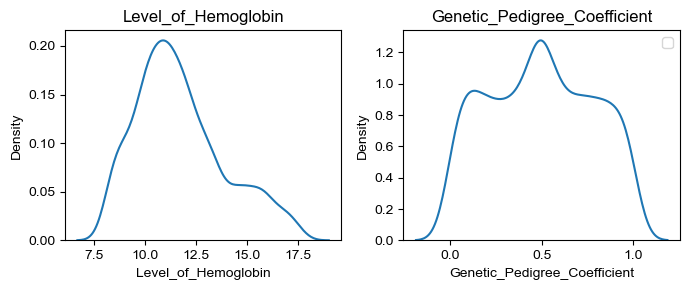

In [44]:
from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(7,3))


for i,b in enumerate(list(df.columns[1:3])):
    
    i +=1
    ax = fig.add_subplot(1,2,i)
    sns.kdeplot(df[b])

    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.show()

A boxplot is plotted here to look for outliers.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


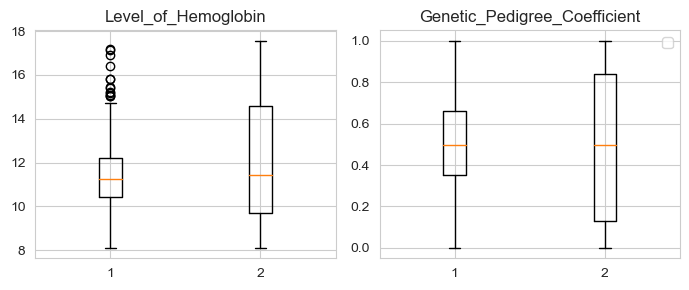

In [45]:

new_df = df.copy() # Making a copy of the original dataframe for ease

df_0 = new_df[new_df['Blood_Pressure_Abnormality'] == 0]
df_1 = new_df[new_df['Blood_Pressure_Abnormality'] == 1]
fig = plt.figure(figsize=(7,3))


for i,b in enumerate(list(new_df.columns[1:10])):
    
    i +=1
    ax = fig.add_subplot(1,2,i)
    ax.boxplot([df_0[b], df_1[b]])

    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.show()

Seems, the feature 'Level_of_Hemoglobin' has some values which could be outliers. We will plot an individual boxplot for clarity.

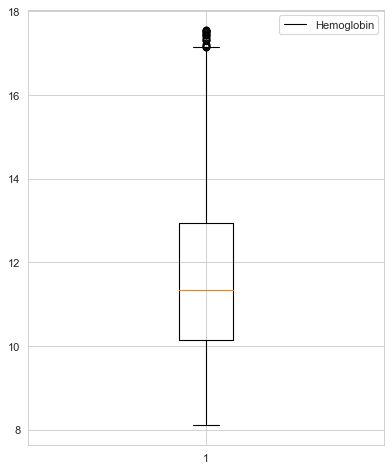

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(5, 6), dpi=80)
plt.boxplot(df["Level_of_Hemoglobin"])
plt.tight_layout()
plt.legend(["Hemoglobin"])
plt.show()

There appears to be some ouliers present. However we will keep them as the values do not appear too far from the IQR limits.

A histogram on the target variable i.e. the "Blood_Pressure_Abnormality" column can tell us about any imbalancement if present.

(array([1013.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         987.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

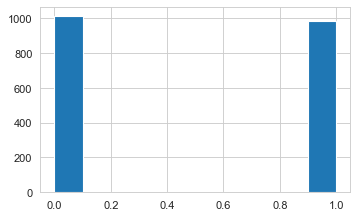

In [47]:
from matplotlib.pyplot import figure

figure(figsize=(5, 3), dpi=80)
plt.hist(df["Blood_Pressure_Abnormality"])

The data appears nearly balanced. So we are overlooking the need for up or down sampling.

#### Bivariate Analysis:

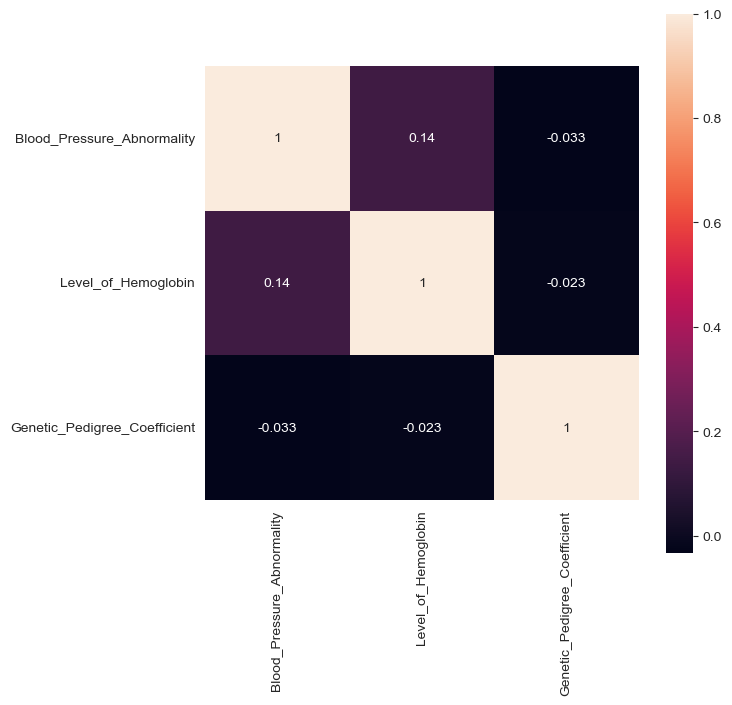

In [48]:
# A correlation heatmap is plotted
corrmat = df.corr()
f,ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat,square=True,annot=True)
plt.show()

There appearts to be little to no correlation among the variables.

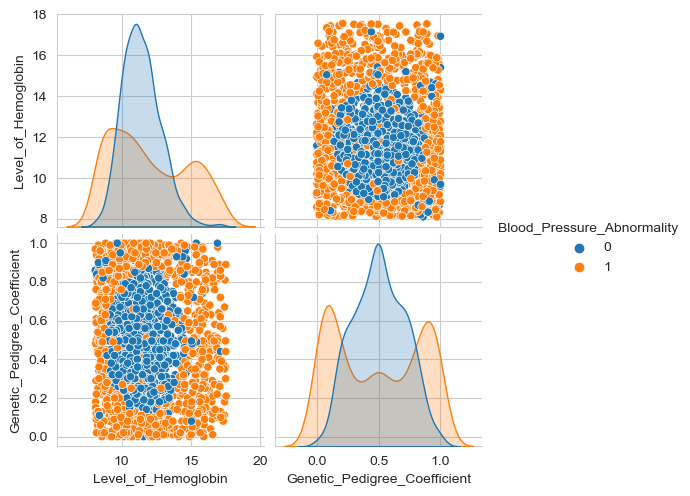

In [49]:
# Scatter plot
sns.pairplot(df, hue= "Blood_Pressure_Abnormality")

### Model Building:
Now that Pre-processing and EDA is done, we will perform the train-test split and build machine learning models to fit on our data.

In [50]:
from sklearn.model_selection import train_test_split
list34 = list(df.columns)
list34.remove('Blood_Pressure_Abnormality')
x = df[list34] # Keeping the predictor variables in x
y = df[["Blood_Pressure_Abnormality"]] # keeping the target variable in y

# A 80-20 split is done 
X_train, X_test, Y_train, Y_test= train_test_split(x, y, test_size=0.2, random_state=52)

As per the requirement, we eed to use **"Different traditional as well as state-of-the-art statistical/Machine Learning techniques, which you are going to use to come up with different models to meet the objective"**<br> 
1. Under the tradition methods we will implement Decision Tree, Logistic Regression, Support Vector Classifier and K nearest neighbour.<br> 
2. Under the state-of-the art machine learning methods we will be implementing various ensemble techniques such as Random Forest, Graduient Boosting, Adaboost.<br> 
3. At the end we will compare the accuracies of all the models. Also we will plot ROC curves and compare the Area under the ROC curves to find out the best model.

### 1. Decision Tree:

In [51]:
pipeline_DecisionTree = Pipeline([("DecisionTree",DecisionTreeClassifier(random_state=52))])

In [52]:
# keeping a range of values of hyperparameters in a dictionary in order to pass them into GridSearchCV
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(
                  DecisionTree__criterion=criterion,
                  DecisionTree__max_depth=max_depth)

# A GridSearchCV will help us find the best combination of hyperparameters to build the optimum model
clf_GS1 = GridSearchCV(pipeline_DecisionTree, parameters)

clf_GS1.fit(X_train, Y_train)

print("The combination of best parameters is :")
print('Best Criterion:', clf_GS1.best_estimator_.get_params()['DecisionTree__criterion'])
print('Best max_depth:', clf_GS1.best_estimator_.get_params()['DecisionTree__max_depth'])
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS1.best_estimator_.get_params()['DecisionTree'])

print("\nThe accuracy so obtained from Decision Tree is: "+str(clf_GS1.best_estimator_.score(X_test, Y_test)))

# Keeping the accuracy value in a dataframe for comparision 
df_classifier = pd.DataFrame({"Classifier": ["Decision Tree"],
                             "Accuracy":[clf_GS1.best_estimator_.score(X_test, Y_test)]})

The combination of best parameters is :
Best Criterion: gini
Best max_depth: 8

The best hyperparameter tuned estimator will be:

DecisionTreeClassifier(max_depth=8, random_state=52)

The accuracy so obtained from Decision Tree is: 0.8875


In [53]:
# A confusion matrix for model evaluation
print(classification_report(Y_train, clf_GS1.best_estimator_.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       812
           1       0.97      0.90      0.93       788

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600



In [54]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS1.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       201
           1       0.92      0.85      0.88       199

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



### 2. Logistic Regression

In [55]:
# Please note that Logistic Regression doesn't have hyerparameters to tune. However we can use different solvers
# and regularization to get the best accuracy

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_Logit = {'solver': solvers, 
              'penalty': penalty,
              'C': c_values}

clf_GS3 = GridSearchCV(LogisticRegression(random_state=52), param_Logit)
clf_GS3.fit(X_train, Y_train)


print("The combination of best parameters is :")
print(clf_GS3.best_params_)
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS3.best_estimator_)
print("\nThe accuracy so obtained from Logistic Regression is: "+str(clf_GS3.best_estimator_.score(X_test, Y_test)))

# Keeping the accuracy value in a dataframe for comparision 
df_Logit = pd.DataFrame({"Classifier": ["Logistic Regression"],
                             "Accuracy":[clf_GS3.best_estimator_.score(X_test, Y_test)]})
df_classifier = df_classifier.append(df_Logit, ignore_index=True)

The combination of best parameters is :
{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

The best hyperparameter tuned estimator will be:

LogisticRegression(C=0.01, random_state=52, solver='newton-cg')

The accuracy so obtained from Logistic Regression is: 0.5775


In [56]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS3.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.69      0.62       201
           1       0.60      0.47      0.52       199

    accuracy                           0.58       400
   macro avg       0.58      0.58      0.57       400
weighted avg       0.58      0.58      0.57       400



### 3. SVC:

In [57]:
# keeping a range of values of hyperparameters in order to pass them into GridSearchCV
param_SVM = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

# GridSearch Cross validation runs all possible combimnations of hyperparameters mentioned 
# above to get the best performing combination
clf_GS2 = GridSearchCV(SVC(probability=True), param_SVM, refit = True)
clf_GS2.fit(X_train, Y_train)


print("The combination of best parameters is :")
print(clf_GS2.best_params_)
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS2.best_estimator_)
print("\nThe accuracy so obtained usig SVC is: "+str(clf_GS2.best_estimator_.score(X_test, Y_test)))

# Keeping the accuracy value in a dataframe for comparision 
df_SVC = pd.DataFrame({"Classifier": ["SVC"],
                             "Accuracy":[clf_GS2.best_estimator_.score(X_test, Y_test)]})
df_classifier = df_classifier.append(df_SVC, ignore_index=True)

The combination of best parameters is :
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

The best hyperparameter tuned estimator will be:

SVC(C=100, gamma=1, probability=True)

The accuracy so obtained usig SVC is: 0.905


In [58]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS2.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       201
           1       0.90      0.90      0.90       199

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.91      0.91      0.91       400



### 4. K Nearest Neighbour:

In [59]:
# keeping a range of values of hyperparameters in order to pass them into GridSearchCV
param_KNN = {'n_neighbors': range(1, 21, 2), 
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}

# GridSearch Cross validation runs all possible combimnations of hyperparameters mentioned 
# above to get the best performing combination
clf_GS5 = GridSearchCV(KNeighborsClassifier(),  param_KNN)
clf_GS5.fit(X_train, Y_train)


print("The combination of best parameters is :")
print(clf_GS5.best_params_)
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS5.best_estimator_)
print("\nThe accuracy so obtained from KNN is: "+str(clf_GS5.best_estimator_.score(X_test, Y_test)))

# Keeping the accuracy value in a dataframe for comparision 
df_KNN = pd.DataFrame({"Classifier": ["KNN"],
                             "Accuracy":[clf_GS5.best_estimator_.score(X_test, Y_test)]})
df_classifier = df_classifier.append(df_KNN, ignore_index=True)


The combination of best parameters is :
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}

The best hyperparameter tuned estimator will be:

KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

The accuracy so obtained from KNN is: 0.895


In [60]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS5.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       201
           1       0.89      0.89      0.89       199

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.90       400



We used the **conventional machine learning algorithms** for classification. We will try implementing a few **state-of-the-art techniques** such as ensemble method, bagging and boosting.

### 5. Random Forest:

In [61]:
# keeping a range of values of hyperparameters in order to pass them into Cross Validation
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
bootstrap = [True, False]
param_RandomF = {'n_estimators': n_estimators, 
              'max_features': max_features,
              'bootstrap': bootstrap}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# GridSearch Cross validation runs all possible combimnations of hyperparameters mentioned 
# above to get the best performing combination
clf_GS4 = GridSearchCV(RandomForestClassifier(random_state=52),  param_RandomF, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
clf_GS4.fit(X_train, Y_train)


print("The combination of best parameters is :")
print(clf_GS4.best_params_)
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS4.best_estimator_)
print("\nThe accuracy so obtained from Random Forest is: "+str(clf_GS4.best_estimator_.score(X_test, Y_test)))

# Keeping the accuracy value in a dataframe for comparision 
df_RF = pd.DataFrame({"Classifier": ["Random Forest"],
                             "Accuracy":[clf_GS4.best_estimator_.score(X_test, Y_test)]})
df_classifier = df_classifier.append(df_RF, ignore_index=True)

The combination of best parameters is :
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 1000}

The best hyperparameter tuned estimator will be:

RandomForestClassifier(n_estimators=1000, random_state=52)

The accuracy so obtained from Random Forest is: 0.8975


In [62]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS4.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       201
           1       0.90      0.89      0.90       199

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



### 6. Gradient Boosting:

In [63]:
# keeping a range of values of hyperparameters in order to pass them into Cross Validation
param_GB = {'learning_rate': arange(0.01, 0.2, 0.02), 
              'n_estimators': [5, 10, 20, 30],
            'max_depth': range(1, 10, 3),
           'criterion': ['friedman_mse', 'mse', 'mae']}

# GridSearch Cross validation runs all possible combimnations of hyperparameters mentioned 
# above to get the best performing combination
clf_GS6 = GridSearchCV(GradientBoostingClassifier(random_state=52),  param_GB)
clf_GS6.fit(X_train, Y_train)

print("The combination of best parameters is :")
print(clf_GS6.best_params_)
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS6.best_estimator_)
print("\nThe accuracy so obtained from Gradient Boosting Classifier is: "+str(clf_GS6.best_estimator_.score(X_test, Y_test)))

# Keeping the accuracy value in a dataframe for comparision 
df_GB = pd.DataFrame({"Classifier": ["GradientBoosting"],
                             "Accuracy":[clf_GS6.best_estimator_.score(X_test, Y_test)]})
df_classifier = df_classifier.append(df_GB, ignore_index=True)


The combination of best parameters is :
{'criterion': 'friedman_mse', 'learning_rate': 0.18999999999999997, 'max_depth': 7, 'n_estimators': 10}

The best hyperparameter tuned estimator will be:

GradientBoostingClassifier(learning_rate=0.18999999999999997, max_depth=7,
                           n_estimators=10, random_state=52)

The accuracy so obtained from Gradient Boosting Classifier is: 0.9


In [64]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS6.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       201
           1       0.92      0.87      0.90       199

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



### 7. Adaboost:

In [67]:
# keeping a range of values of hyperparameters in order to pass them into GridSearchCV

# here as a base estimator we have used the Decision Tree with the best hyperparameter values we got before.
# The default base estimator is also a decision tree classifier with max_depth=1
#param_AB = {'base_estimator':[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
 #                      max_features=None, max_leaf_nodes=None,
  #                     min_impurity_decrease=0.0, min_impurity_split=None,
   #                    min_samples_leaf=1, min_samples_split=2,
    #                   min_weight_fraction_leaf=0.0, presort=False,
     #                  random_state=52, splitter='best')], 
      #      'learning_rate': arange(0.01, 0.2, 0.02), 
       #     'n_estimators': [10, 100, 2000]}
param_AB = {'base_estimator':[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=52, splitter='best')], 
            'learning_rate': arange(0.01, 0.2, 0.02), 
            'n_estimators': [10, 100, 2000]}


# GridSearch Cross validation runs all possible combimnations of hyperparameters mentioned 
# above to get the best performing combination
clf_GS7 = GridSearchCV(AdaBoostClassifier(random_state=52,algorithm='SAMME.R'),  param_AB)
clf_GS7.fit(X_train, Y_train)


print("The combination of best parameters is :")
print(clf_GS7.best_params_)
print("\nThe best hyperparameter tuned estimator will be:")
print(); print(clf_GS7.best_estimator_)
print("\nThe accuracy so obtained from Gradient Boosting Classifier is: "+str(clf_GS7.best_estimator_.score(X_test, Y_test)))


# Keeping the accuracy value in a dataframe for comparision 
df_AB = pd.DataFrame({"Classifier": ["AdaBoost"],
                             "Accuracy":[clf_GS7.best_estimator_.score(X_test, Y_test)]})
df_classifier = df_classifier.append(df_AB, ignore_index=True)


The combination of best parameters is :
{'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=52), 'learning_rate': 0.16999999999999998, 'n_estimators': 2000}

The best hyperparameter tuned estimator will be:

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=8,
                                                         random_state=52),
                   learning_rate=0.16999999999999998, n_estimators=2000,
                   random_state=52)

The accuracy so obtained from Gradient Boosting Classifier is: 0.885


In [68]:
#Classification report for test data:
print(classification_report(Y_test, clf_GS7.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       201
           1       0.90      0.86      0.88       199

    accuracy                           0.89       400
   macro avg       0.89      0.88      0.88       400
weighted avg       0.89      0.89      0.88       400



### Comparision:

Now that we have executed a few models, we will try making a comparision of their accuracies and check which algorithm gives us the best accuracy.

In [69]:
df_classifier.sort_values("Accuracy",ascending=False)

,Classifier,Accuracy
2,SVC,0.9050
5,GradientBoosting,0.9000
4,Random Forest,0.8975
3,KNN,0.8950
0,Decision Tree,0.8875
6,AdaBoost,0.8850
1,Logistic Regression,0.5775


Accuracy alone is not always a reliable measure. Hence we will plot ROC Curve and find the AUC values for each algorithm and compare them to see which model is superior. ROC is for visual inspection. Hence Area Under the ROC curve could give us a clear picture.

### ROC, AUC :

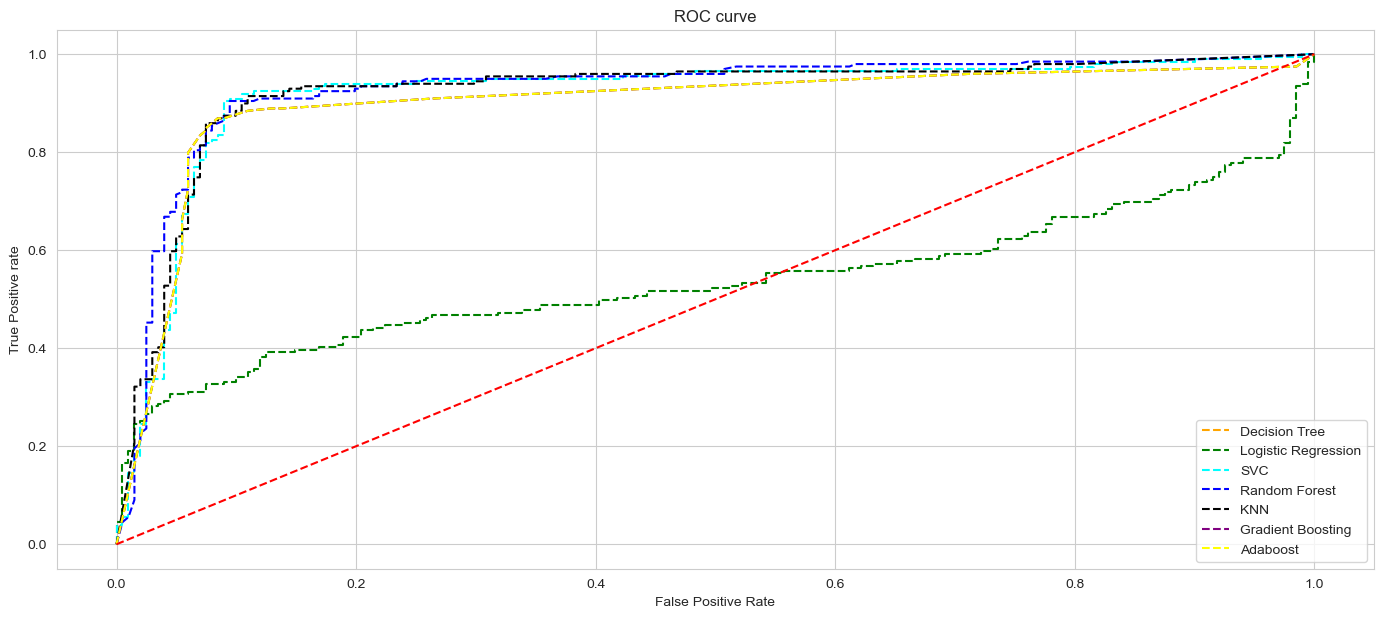

In [70]:
# Predict_proba will give the prediction probabilities over X_test here for the range of estimators we used
pred_prob_KNN = clf_GS5.best_estimator_.predict_proba(X_test)
pred_prob_RF = clf_GS4.best_estimator_.predict_proba(X_test)
pred_prob_SVC = clf_GS2.best_estimator_.predict_proba(X_test)
pred_prob_Logit = clf_GS3.best_estimator_.predict_proba(X_test)
pred_prob_DT = clf_GS1.best_estimator_.predict_proba(X_test)
pred_prob_GB = clf_GS1.best_estimator_.predict_proba(X_test)
pred_prob_AB = clf_GS1.best_estimator_.predict_proba(X_test)

# True Positive Rate & False Positive Rate for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob_DT[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(Y_test, pred_prob_Logit[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(Y_test, pred_prob_SVC[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(Y_test, pred_prob_RF[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(Y_test, pred_prob_KNN[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(Y_test, pred_prob_GB[:,1], pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(Y_test, pred_prob_AB[:,1], pos_label=1)

# roc curve for tpr = fpr i.e. a diagonal straight line
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

# plot roc curves
fig = plt.figure(figsize=(17,7))
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression')
plt.plot(fpr3, tpr3, linestyle='--',color='cyan', label='SVC')
plt.plot(fpr4, tpr4, linestyle='--',color='blue', label='Random Forest')
plt.plot(fpr5, tpr5, linestyle='--',color='black', label='KNN')
plt.plot(fpr6, tpr6, linestyle='--',color='purple', label='Gradient Boosting')
plt.plot(fpr7, tpr7, linestyle='--',color='yellow', label='Adaboost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

In [71]:
# The AUC values will give us a clearer picture as the ROC curves for some of the algorithms are overlapping.
df_AUC = pd.DataFrame({"Classifier": ["Decision Tree_AUC", 'Logit_AUC', 'SVC_AUC', 'RandomF_AUC', 'KNN_AUC', 'GradientBoosting_AUC','Adaboost_AUC'],
                             "AUC":[metrics.auc(fpr1, tpr1), metrics.auc(fpr2, tpr2), metrics.auc(fpr3, tpr3), metrics.auc(fpr4, tpr4), metrics.auc(fpr5, tpr5),metrics.auc(fpr6, tpr6),metrics.auc(fpr7, tpr7)]})
df_AUC.sort_values("AUC", ascending = False)

,Classifier,AUC
3,RandomF_AUC,0.927036
4,KNN_AUC,0.921561
2,SVC_AUC,0.917723
0,Decision Tree_AUC,0.898622
5,GradientBoosting_AUC,0.898622
6,Adaboost_AUC,0.898622
1,Logit_AUC,0.535863


In [72]:
df_classifier.sort_values("Accuracy",ascending=False)

,Classifier,Accuracy
2,SVC,0.9050
5,GradientBoosting,0.9000
4,Random Forest,0.8975
3,KNN,0.8950
0,Decision Tree,0.8875
6,AdaBoost,0.8850
1,Logistic Regression,0.5775


**Conclusion: From the above analysis we can safely conclude that the random forest is the best estimator among the algorithms we compared. With this we are achieving a test accuracy of 89.75% and an AUC value of 0.927.**